In [1]:
import csv
from pyspark import SparkContext
import timeit
import datetime
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import os
sc=SparkContext()
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

24/12/22 17:33:03 WARN Utils: Your hostname, Zhijie resolves to a loopback address: 127.0.1.1; using 192.168.93.152 instead (on interface wlo1)
24/12/22 17:33:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/22 17:33:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/22 17:33:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/12/22 17:33:04 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
def configure_data(line):
    """
    Convierte una línea del archivo CSV en un par clave-valor.

    Args:
        line (str): Línea del archivo CSV.

    Returns:
        tuple: Una tupla `(key, value)` donde:
            - `key`: Tupla `(User, Model, gt)` como identificador.
            - `value`: Tupla con datos para cálculos agregados.
        Devuelve `(None, None)` si el valor `gt` es `'null'`.
    """
    datas = line.split(',')
    if datas[9] == 'null':
        return None, None

    x = float(datas[3])
    y = float(datas[4])
    z = float(datas[5])
    key = (datas[6], datas[7], datas[9])
    value = (
        x, y, z,
        x**2, y**2, z**2,
        x, y, z,
        x, y, z,
        1
    )

    return key, value

def filter_data(data):
    """
    Filtra registros con claves nulas.

    Args:
        data (tuple): Una tupla `(key, value)`.

    Returns:
        bool: `True` si la clave no es `None`, de lo contrario `False`.
    """
    key, _ = data
    if key is None:
        return False
    return True

def reduce_data(a, b):
    """
    Combina dos tuplas de datos para agregar valores (sumatorias, mínimos, máximos, conteo).

    Args:
        a (tuple): Primera tupla con valores acumulados.
        b (tuple): Segunda tupla con valores acumulados.

    Returns:
        tuple: Una tupla con los valores combinados.
    """
    sum_x = a[0] + b[0]
    sum_y = a[1] + b[1]
    sum_z = a[2] + b[2]
    sum_x2 = a[3] + b[3]
    sum_y2 = a[4] + b[4]
    sum_z2 = a[5] + b[5]
    max_x = max(a[6], b[6])
    max_y = max(a[7], b[7])
    max_z = max(a[8], b[8])
    min_x = min(a[9], b[9])
    min_y = min(a[10], b[10])
    min_z = min(a[11], b[11])
    count = a[12] + b[12]
    return (
        sum_x, sum_y, sum_z,
        sum_x2, sum_y2, sum_z2,
        max_x, max_y, max_z,
        min_x, min_y, min_z,
        count
    )

def calculate_data(data):
    """
    Calcula métricas como la media, desviación estándar, máximo y mínimo por eje.

    Args:
        data (tuple): Tupla `(key, aggregated_values)`.

    Returns:
        tuple: Tupla `(key, metrics)` donde `metrics` incluye las métricas calculadas.
    """
    key, value = data
    sum_x, sum_y, sum_z, sum_x2, sum_y2, sum_z2, max_x, max_y, max_z, min_x, min_y, min_z, count = value
    mean_x = sum_x / count
    mean_y = sum_y / count
    mean_z = sum_z / count
    std_x = (sum_x2 / count - mean_x**2)**0.5
    std_y = (sum_y2 / count - mean_y**2)**0.5
    std_z = (sum_z2 / count - mean_z**2)**0.5
    return key, (mean_x, mean_y, mean_z, std_x, std_y, std_z, max_x, max_y, max_z, min_x, min_y, min_z)

def simplify_data(data):
    """
    Combina datos de giroscopios y acelerómetros en una sola estructura.

    Args:
        data (tuple): Tupla `(key, (value1, value2))`.

    Returns:
        tuple: Tupla `(key, combined_values)` con todos los datos combinados.
    """
    key, (value1, value2) = data
    combined_values = value1 + value2
    return key, combined_values

def split_data(data):
    datas = data.split(',')
    # We use bool for unused column to reduce memory usage
    return bool(datas[0]), bool(datas[1]), bool(datas[2]), float(datas[3]), float(datas[4]), float(datas[5]), datas[6], datas[7], datas[8], datas[9]

def load_and_preprocess(file_path, schema):
    return spark.read.csv(file_path, schema=schema, nullValue="null")

def compute_group_statistics(data):
    return data.groupBy(data['user'], data['model'], data['gt']).agg(
        F.mean(data['x']).alias('mean_x'),
        F.mean(data['y']).alias('mean_y'),
        F.mean(data['z']).alias('mean_z'),
        F.stddev(data['x']).alias('std_x'),
        F.stddev(data['y']).alias('std_y'),
        F.stddev(data['z']).alias('std_z'),
        F.max(data['x']).alias('max_x'),
        F.max(data['y']).alias('max_y'),
        F.max(data['z']).alias('max_z'),
        F.min(data['x']).alias('min_x'),
        F.min(data['y']).alias('min_y'),
        F.min(data['z']).alias('min_z')
    )
def get_parquet_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            total_size += os.path.getsize(file_path)
    return total_size

def get_csv_file_size(file_path):
    if os.path.isfile(file_path):
        file_size = os.path.getsize(file_path)
        return file_size
    else:
        raise FileNotFoundError(f"The file '{file_path}' does not exist.")

fields = [
    StructField("_index", BooleanType(), False), StructField("_arrive", BooleanType(), False), StructField("_creation", BooleanType(), False),
    StructField("x", DoubleType(), False), StructField("y", DoubleType(), False), StructField("z", DoubleType(), False),
    StructField("user", StringType(), False), StructField("model", StringType(), False), StructField("_device", StringType(), False),
    StructField("gt", StringType(), False)
]
schema = StructType(fields)

In [3]:
ori_folder = "original/"
sml_folder = "small/"

file_names = ["Phones_accelerometer", "Phones_gyroscope", "Watch_accelerometer", "Watch_gyroscope"]

for file_name in file_names:
    if not os.path.exists(sml_folder+file_name+".parquet"):
        data = load_and_preprocess(sml_folder+file_name+".csv", schema)
        data.write.save(sml_folder+file_name+".parquet")
    
    if not os.path.exists(ori_folder+file_name+".parquet"):
        data = load_and_preprocess(ori_folder+file_name+".csv", schema)
        data.write.save(ori_folder+file_name+".parquet")


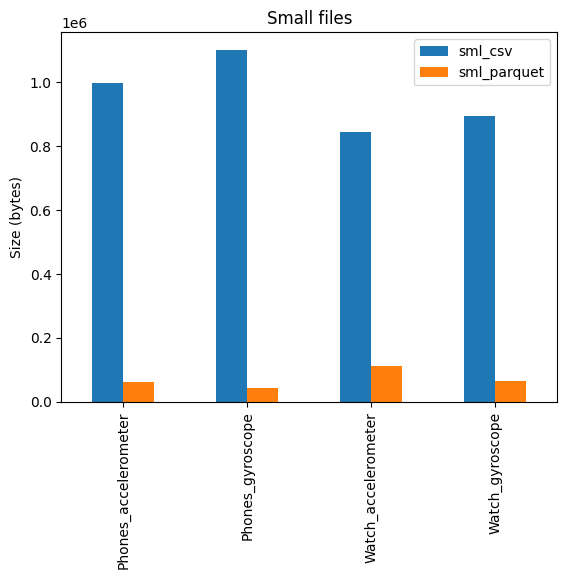

                      sml_csv  sml_parquet
Phones_accelerometer   997515        61409
Phones_gyroscope      1100646        42037
Watch_accelerometer    842763       111834
Watch_gyroscope        894796        65614


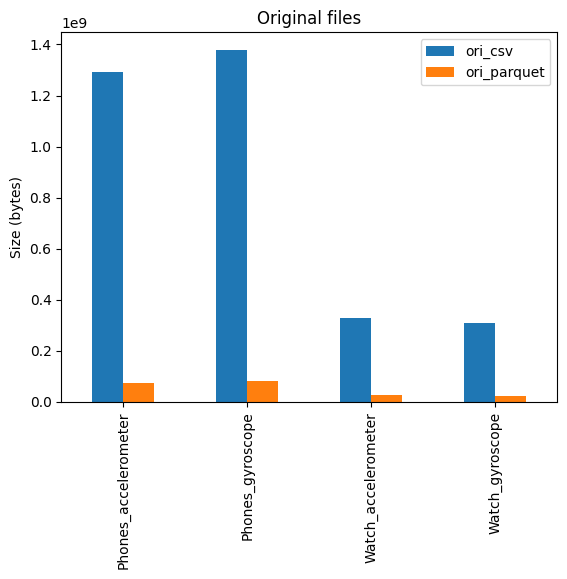

                         ori_csv  ori_parquet
Phones_accelerometer  1291856327     73804953
Phones_gyroscope      1379145657     80561783
Watch_accelerometer    327168052     26367149
Watch_gyroscope        308337025     22012309


24/12/22 17:33:16 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
ori_csv = []
sml_csv = []
ori_parquet = []
sml_parquet = []

for file_name in file_names:
    ori_csv.append(get_csv_file_size(ori_folder+file_name+".csv"))
    sml_csv.append(get_csv_file_size(sml_folder+file_name+".csv"))
    ori_parquet.append(get_parquet_folder_size(ori_folder+file_name+".parquet"))
    sml_parquet.append(get_parquet_folder_size(sml_folder+file_name+".parquet"))

sm_df = pd.DataFrame({
    "sml_csv": sml_csv,
    "sml_parquet": sml_parquet
}, index=file_names)

sm_df.plot(kind='bar')
plt.title("Small files")
plt.ylabel("Size (bytes)")
plt.show()
print(sm_df)

or_df = pd.DataFrame({
    "ori_csv": ori_csv,
    "ori_parquet": ori_parquet
}, index=file_names)

or_df.plot(kind='bar')
plt.title("Original files")
plt.ylabel("Size (bytes)")
plt.show()
print(or_df)

In [5]:
a = datetime.datetime.now()
data1 = sc.textFile(sml_folder+'Phones_accelerometer.csv', 8)
data2 = sc.textFile(sml_folder+'Phones_gyroscope.csv', 8)
data3 = sc.textFile(sml_folder+'Watch_accelerometer.csv', 8)
data4 = sc.textFile(sml_folder+'Watch_gyroscope.csv', 8)

r_data1 = data1.map(configure_data).filter(filter_data).reduceByKey(reduce_data).map(calculate_data)
r_data2 = data2.map(configure_data).filter(filter_data).reduceByKey(reduce_data).map(calculate_data)
r_data3 = data3.map(configure_data).filter(filter_data).reduceByKey(reduce_data).map(calculate_data)
r_data4 = data4.map(configure_data).filter(filter_data).reduceByKey(reduce_data).map(calculate_data)

phones = r_data1.join(r_data2).map(simplify_data)
watch = r_data3.join(r_data4).map(simplify_data)

result = phones.union(watch).collect()
b = datetime.datetime.now()
print (b-a)
result

0:00:02.862581


[(('a', 'nexus4', 'stand'),
  (-6.026499950569997,
   0.9334959509016004,
   8.013646013120006,
   0.184551746735394,
   0.24043415892743478,
   0.17599985821395306,
   -5.5202026,
   1.9472808999999998,
   8.638794,
   -7.0448303,
   -0.84251404,
   7.149872,
   0.0015888519490950034,
   0.0010094604656469997,
   0.00044218442934899877,
   0.04277492705495176,
   0.028613015987344483,
   0.045941044056574176,
   0.6321869000000001,
   0.34971620000000003,
   0.44873047,
   -0.16569519,
   -0.15550232,
   -0.6001586999999999)),
 (('a', 'gear', 'stand'),
  (-9.289753201219128,
   -3.137156524200753,
   -1.066286300996938,
   0.41370414741585154,
   1.0628532344784418,
   0.6173240991928323,
   -0.5650316,
   -0.5781997,
   1.01574,
   -12.600683,
   -11.08276,
   -2.2625206,
   0.022146662344973242,
   -0.03286732380555579,
   -0.07143672518383197,
   0.07314944656109791,
   0.05570243854351144,
   0.050177495900925566,
   0.81039995,
   0.35446674,
   1.1475562,
   -2.0383835,
   -0.55

In [7]:
a = datetime.datetime.now()
data1 = spark.createDataFrame(sc.textFile(sml_folder+'Phones_accelerometer.csv', 8).map(split_data), schema)
data2 = spark.createDataFrame(sc.textFile(sml_folder+'Phones_gyroscope.csv', 8).map(split_data), schema)
data3 = spark.createDataFrame(sc.textFile(sml_folder+'Watch_accelerometer.csv', 8).map(split_data), schema)
data4 = spark.createDataFrame(sc.textFile(sml_folder+'Watch_gyroscope.csv', 8).map(split_data), schema)

group1 = compute_group_statistics(data1)
group2 = compute_group_statistics(data2)
group3 = compute_group_statistics(data3)
group4 = compute_group_statistics(data4)

join1 = group1.join(group2, ['user', 'model', 'gt'], 'inner')
join2 = group3.join(group4, on=['user', 'model', 'gt'], how='inner')

results = join1.union(join2).collect()
b = datetime.datetime.now()
print (b-a)
results

0:00:00.804481


[Row(user='a', model='nexus4', gt='stand', mean_x=-6.026499950569997, mean_y=0.9334959509016004, mean_z=8.013646013120006, std_x=0.18456097501476815, std_y=0.24044618153708075, std_z=0.17600865886717226, max_x=-5.5202026, max_y=1.9472808999999998, max_z=8.638794, min_x=-7.0448303, min_y=-0.84251404, min_z=7.149872, mean_x=0.0015888519490950034, mean_y=0.0010094604656469997, mean_z=0.00044218442934899877, std_x=0.04277706596172397, std_y=0.028614446745451546, std_z=0.04594334128107022, max_x=0.6321869000000001, max_y=0.34971620000000003, max_z=0.44873047, min_x=-0.16569519, min_y=-0.15550232, min_z=-0.6001586999999999),
 Row(user='a', model='gear', gt='stand', mean_x=-9.289753201219128, mean_y=-3.137156524200753, mean_z=-1.066286300996938, std_x=0.4137450252528024, std_y=1.0629582543131464, std_z=0.6173850965843359, max_x=-0.5650316, max_y=-0.5781997, max_z=1.01574, min_x=-12.600683, min_y=-11.08276, min_z=-2.2625206, mean_x=0.022146662344973242, mean_y=-0.03286732380555579, mean_z=-0.0

In [8]:
a = datetime.datetime.now()
data1 = spark.read.load(sml_folder+"Phones_accelerometer.parquet")
data2 = spark.read.load(sml_folder+"Phones_gyroscope.parquet")
data3 = spark.read.load(sml_folder+"Watch_accelerometer.parquet")
data4 = spark.read.load(sml_folder+"Watch_gyroscope.parquet")

group1 = compute_group_statistics(data1)
group2 = compute_group_statistics(data2)
group3 = compute_group_statistics(data3)
group4 = compute_group_statistics(data4)

join1 = group1.join(group2, ['user', 'model', 'gt'], 'inner')
join2 = group3.join(group4, on=['user', 'model', 'gt'], how='inner')

results = join1.union(join2).collect()
b = datetime.datetime.now()
print (b-a)
results

0:00:01.163836


[Row(user='a', model='nexus4', gt='stand', mean_x=-6.02649995057012, mean_y=0.9334959509016011, mean_z=8.013646013119995, std_x=0.1845609750147674, std_y=0.24044618153707975, std_z=0.17600865886717884, max_x=-5.5202026, max_y=1.9472808999999998, max_z=8.638794, min_x=-7.0448303, min_y=-0.84251404, min_z=7.149872, mean_x=0.0015888519490950379, mean_y=0.001009460465647035, mean_z=0.00044218442934900517, std_x=0.042777065961724134, std_y=0.02861444674545153, std_z=0.045943341281070235, max_x=0.6321869000000001, max_y=0.34971620000000003, max_z=0.44873047, min_x=-0.16569519, min_y=-0.15550232, min_z=-0.6001586999999999),
 Row(user='a', model='gear', gt='stand', mean_x=-9.28975320121918, mean_y=-3.1371565242007433, mean_z=-1.0662863009969377, std_x=0.4137450252528032, std_y=1.0629582543131455, std_z=0.617385096584336, max_x=-0.5650316, max_y=-0.5781997, max_z=1.01574, min_x=-12.600683, min_y=-11.08276, min_z=-2.2625206, mean_x=0.022146662344973197, mean_y=-0.03286732380555572, mean_z=-0.071

In [44]:
a = datetime.datetime.now()
data1 = load_and_preprocess(ori_folder+"Phones_accelerometer.csv", schema)
data2 = load_and_preprocess(ori_folder+"Phones_gyroscope.csv", schema)
data3 = load_and_preprocess(ori_folder+"Watch_accelerometer.csv", schema)
data4 = load_and_preprocess(ori_folder+"Watch_gyroscope.csv", schema)

group1 = compute_group_statistics(data1)
group2 = compute_group_statistics(data2)
group3 = compute_group_statistics(data3)
group4 = compute_group_statistics(data4)

join1 = group1.join(group2, ['user', 'model', 'gt'], 'inner')
join2 = group3.join(group4, on=['user', 'model', 'gt'], how='inner')

results = join1.union(join2).collect()
b = datetime.datetime.now()
print (b-a)
results

0:00:10.072972
